# **Stratification: Monte Carlo and Simulation**

In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm # ajouté pour la q3
from scipy.stats.qmc import Sobol # ajouté pour la q3

## **Question 1**

We define the function $f$:

In [2]:
def f(u):
    return np.cos(2 * np.pi * (np.mean(u) - 1/2))

### **Monte-Carlo**

Notice that $I := \int_{[0, 1]^d} f(u) du = \mathbb{E}_{U \sim \mathcal{U}([0, 1]^d)}[f(U)]$. Thus, we can approximate $I$ using Monte Carlo.

In [ ]:
def montecarlo(d, N = 10000):
    """
    Estimates the expected value of a function using the Monte Carlo method.

    Parameters:
    - d: The dimension of the hypercube the function f is defined on.
    - N: The number of Monte Carlo simulations (default is 10,000).

    Returns:
    - The empirical mean of the function evaluations, approximating the expected value.
    """

    X = [f(rd.random(d)) for _ in range(N)]
    return np.mean(X)

Here are the results for different values of `N`:

In [4]:
d_values = [1, 2, 3, 5, 10, 100]
N_values = [100, 1000, 10000]

data = {N: [montecarlo(d, N) for d in d_values] for N in N_values}

df = pd.DataFrame(data, index = d_values)
df.iloc[:len(d_values)]

,100,1000,10000
1,0.085617,-0.001480,-0.000678
2,0.384960,0.414720,0.406361
3,0.509239,0.543971,0.561972
5,0.755660,0.716419,0.724930
10,0.873834,0.849471,0.847814
100,0.981670,0.984381,0.983946


### **Quasi-Monte-Carlo**

For quasi-MC and for $d > 1$, like in the course slides, we need to generate $N$ points $u_1, \dots, u_N$ such that exactly one point falls in each strip of $\left\{\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right\}^d$.

This is the goal of the function `generate_indices()`.

For the sake of clarity, instead of directly generating the points in $\left\{\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right\}^d$, we will first generate them in $\{0, 1, \dots, N - 1\}^d$ and then apply the function $x \longmapsto \frac{2x + 1}{2N}$ to each coordinate of the output vector.

For $d = 2$, the above problem boils down to generating a permutation matrix $M = (m_{i, j}) \in \mathbb{R}^{N \times N}$, i.e. $m_{i, j} = \mathbf{1}_{i = \sigma(j)}$ for some permutation $\sigma$ of the set $\{0, 1, \dots, N - 1\}$.

For any $d \geq 2$, this boils down to generating a $d$-dimensional table $M = (m_{i_1, \dots, i_d}) \in \mathbb{R}^{N^d}$ such that$$m_{i_1, \dots, i_d} = \mathbf{1}_{i_1 = \sigma_2(i_2) = \cdots = \sigma_d(i_d)}$$where $\sigma_2, \dots, \sigma_d$ are $d - 1$ permutations of $\{0, 1, \dots, N - 1\}$.

The permutations are generated independently and uniformly on the (finite) set of permutations $\mathfrak{S}(\{0, 1, \dots, N - 1\})$.

In [ ]:
def generate_indices(d, N = 10000):
    """
    Generates a vector of N points (u_1, ..., u_N) such that exactly one point falls in each strip of {1/(2N), 3/(2N), ..., (2N - 1)/(2N)}^d

    Parameters:
    - d: The dimension of the hypercube the function f is defined on.
    - N: The number of Monte Carlo simulations (default is 10,000).

    Returns:
    - A numpy array of size (N, d), representing the desired vector.
    """

    list_indices = []
    X = []
    arr = np.array(list(range(N)))

    # Generate perm such that perm[k] is the matrix M = (m_{i, j}) of the permutation \sigma_{k + 2}^{-1}
    perm = [rd.permutation(arr) for _ in range(d - 1)]

    for i in range(N):
        # For all k = 1, ... N - 1, get the value of \sigma_{k + 2}^{-1}(i), i.e. the indice j such that m_{i, j} = 1
        indices = [i] + [perm[k][i] for k in range(d - 1)]
        list_indices.append(indices)

    list_indices = np.array(list_indices)
    list_indices = (2 * list_indices + 1)/(2 * N)
    return list_indices

Let's visualize what this function does.

Case $d = 2$: this is what `generate_indices(2, 10)` corresponds to:

[[0.05 0.45]
 [0.15 0.35]
 [0.25 0.05]
 [0.35 0.55]
 [0.45 0.75]
 [0.55 0.25]
 [0.65 0.95]
 [0.75 0.65]
 [0.85 0.15]
 [0.95 0.85]]


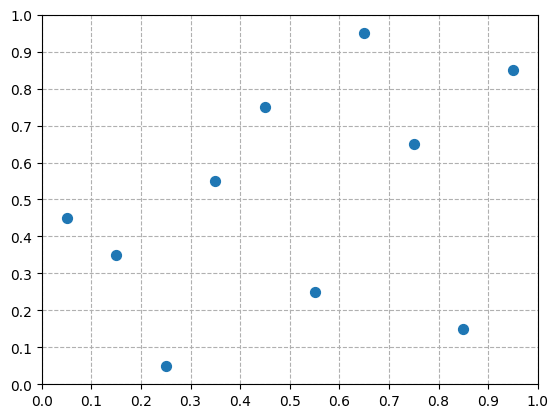

In [6]:
points = generate_indices(2, 10)

print(points)

x = points[:, 0]
y = points[:, 1]

plt.scatter(x, y, s = 50)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle = '--')
plt.show()

Case $d = 3$: this is what `generate_indices(3, 10)` corresponds to:

[[0.05 0.25 0.55]
 [0.15 0.55 0.05]
 [0.25 0.05 0.25]
 [0.35 0.65 0.65]
 [0.45 0.35 0.45]
 [0.55 0.75 0.75]
 [0.65 0.45 0.15]
 [0.75 0.95 0.85]
 [0.85 0.85 0.95]
 [0.95 0.15 0.35]]


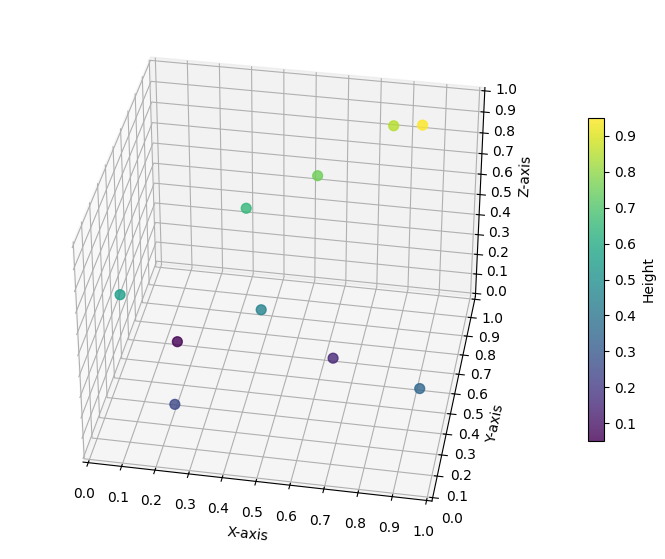

In [7]:
points = generate_indices(3, 10)

print(points)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

# Grid
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_zticks(np.linspace(0, 1, 11))
ax.grid(True, linestyle = '--')

# Point of view
ax.view_init(elev = 35, azim = -80)

# The color is a function of height
sc = ax.scatter(x, y, z,
                c = z,
                cmap = 'viridis',
                s = 50,
                alpha = 0.8)
cbar = plt.colorbar(sc, ax = ax, shrink = 0.6)
cbar.set_label("Height")

# Label of each axes
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

An interactive version of the above graph can be plotted using `plotly`:

In [8]:
import plotly.graph_objects as go

# Générer les points
points = generate_indices(3, 10)
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Création du scatter plot 3D interactif avec Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Couleur en fonction de la hauteur
        colorscale='viridis',
        opacity=0.8
    )
))

# Mise en forme des axes et du fond
fig.update_layout(
    title="Graphique 3D Interactif",
    scene=dict(
        xaxis=dict(title="X-axis", showgrid=True, gridcolor="lightgray"),
        yaxis=dict(title="Y-axis", showgrid=True, gridcolor="lightgray"),
        zaxis=dict(title="Z-axis", showgrid=True, gridcolor="lightgray"),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Affichage interactif
fig.show()

Henceforth, we may use the function `generate_indices()` to generate a vector $(u_1, \dots, u_N)$ as described above, and return the mean of $X = (f(u_1), \dots, f(u_N))$.
- For $d = 1$, the function is not needed, we simply use $(u_1, \dots, u_N) = \left(\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right)$ ;
- For $d > 1$, the vector $(u_1, \dots, u_N)$ is given by the output of `generate_indices(d, N)`.

In [9]:
def quasimontecarlo(d, N = 10000):
    if d == 1:
        X = [f((2 * n + 1)/(2 * N)) for n in range(N)]
    if d > 1:
        list_indices = generate_indices(d, N)
        X = [f(u) for u in list_indices]
    return np.mean(X)

For $d = 1$, we have $I = \int_0^1 \cos\left(2 \pi \left(u - \frac{1}{2}\right)\right) du = \frac{1}{2\pi} \int_{-\pi}^\pi \cos(t) dt = 0$. We can see below that quasi-MC is much better than MC.

In [10]:
float(montecarlo(1)), float(quasimontecarlo(1))

(0.0142886841859915, 4.5474735088646414e-17)

For $d > 1$: bon ça marche mais c'est trop bizarre car c'est à peu du même ordre que MC...

In [11]:
m1 = np.mean([montecarlo(2) for _ in range(10)])
m2 = np.mean([quasimontecarlo(2) for _ in range(10)])
v1 = np.var([montecarlo(2) for _ in range(10)])
v2 = np.var([quasimontecarlo(2) for _ in range(10)])
float(m1), float(m2), float(v1), float(v2)

(0.40550274221976335,
 0.4063451946099428,
 1.4288469197828847e-05,
 1.998308967617496e-05)

## **Question 2**

Let
$$\begin{aligned} \mathfrak{C}_k := &\left\{\left(\frac{2j_1 + 1}{2k}, \dots, \frac{2j_d + 1}{2k}\right) \quad \text{s.t.} \quad (j_1, \dots, j_d) \in \{0, 1, \dots, k - 1\}^d\right\} \\ = &\left\{\frac{1}{2k}, \frac{3}{2k}, \dots, \frac{2k - 1}{2k}\right\}^d \end{aligned}$$

Haber's first estimator is defined by
$$\hat{I}_{1,k}(f) := \frac{1}{k^d} \sum_{c \in \mathfrak{C}_k} f(c + U_c), \quad U_c \sim \mathcal{U}\left(\left[-\frac{1}{2k}, \frac{1}{2k}\right]^d\right)$$

To implement this estimor, we will first write a function that generates all the points that $\mathfrak{C}_k$ contains:

In [ ]:
import itertools
def c_0k(d, k):
    """
    Generates all points of C_k.

    Parameters:
    - d: The dimension of the hypercube the function f is defined on.
    - k: A parameter that represents the precision of the "grid" C_k.

    Returns:
    - A numpy array of size (k^d, d), which lines represent all the elements of C_k.
    """
    return np.array([[(2*j + 1) / (2*k) for j in point] for point in itertools.product(range(k), repeat=d)])


In [13]:
c_0k(2, 5)

array([[0.1, 0.1],
       [0.1, 0.3],
       [0.1, 0.5],
       [0.1, 0.7],
       [0.1, 0.9],
       [0.3, 0.1],
       [0.3, 0.3],
       [0.3, 0.5],
       [0.3, 0.7],
       [0.3, 0.9],
       [0.5, 0.1],
       [0.5, 0.3],
       [0.5, 0.5],
       [0.5, 0.7],
       [0.5, 0.9],
       [0.7, 0.1],
       [0.7, 0.3],
       [0.7, 0.5],
       [0.7, 0.7],
       [0.7, 0.9],
       [0.9, 0.1],
       [0.9, 0.3],
       [0.9, 0.5],
       [0.9, 0.7],
       [0.9, 0.9]])

In [ ]:
def haber_estimator_1(d, k, N = 10000):
    c_0k_point = c_0k(d, k)
    U_c = rd.uniform(-1/(2*k), 1/(2*k), size = (N, d))
    X = [f(u + c) for c,u in zip(c_0k_point, U_c)]
    return np.mean(X)

In [15]:
m = np.mean([haber_estimator_1(2,5) for _ in range(10)])
v = np.var([haber_estimator_1(2,5) for _ in range(10)])
float(m), float(v)

(0.4049206312473144, 0.0006670155850212904)

Let
$$g_c(u) := \frac{f(c + u) + f(c - u)}{2}$$

Haber's second estimator is the following:
$$\hat{I}_{2,k}(f) := \frac{1}{k^d} \sum_{c \in \mathfrak{C}_k} g_c(U_c), \quad U_c \sim \mathcal{U}\left(\left[-\frac{1}{2k}, \frac{1}{2k}\right]^d\right)$$


In [ ]:
def haber_estimator_2(d, k, N = 10000):
    c_0k_point = c_0k(d, k)
    U_c = rd.uniform(-1/(2*k), 1/(2*k), size = (N, d))
    X = [(f(c + u) + f(c - u))/2 for c,u in zip(c_0k_point, U_c)]
    return np.mean(X)

In [17]:
float(haber_estimator_1(2,5)), float(haber_estimator_2(2,5))

(0.3330392189724504, 0.4020370481040881)

In [18]:
m = np.mean([haber_estimator_2(2,5) for _ in range(10)])
v = np.var([haber_estimator_2(2,5) for _ in range(10)])
float(m), float(v)

(0.40688936077421783, 1.9909045973892413e-05)

## **Question 3**
### **Approximation of the integral using importance sampling**

Assuming $u_1, \dots, u_d \overset{\text{i.i.d.}}{\sim} \mathcal{U}([0, 1])$, the central limit theorem enables us to make the following approximation :

$$
\frac{1}{d} \sum_{i = 1}^d u_i \sim \mathcal{N}\left(0.5, \frac{1}{12d}\right) \quad \text{when } d \text{ is large}.
$$

This allows us to construct an importance sampling strategy to efficiently evaluate this integral.

We will generate samples $u \in [0, 1]^d$ where the mean approximately follows a normal distribution centered at $0.5$, with variance $\frac{1}{12d}$.

Then, we adjust the weights with the normal density to correct for bias, as in the importance sampling formula:

$$
I \approx \frac{1}{N} \sum_{i=1}^N \frac{f(u^{(i)})}{p(u^{(i)})}
$$

*TODO : Il faudrait définir ce qu'est la densité $p$ ici, et refaire le code qui suit de sorte que les variables soient samplées selon $p$.*

In [19]:
def importance_sampling(f, d, N, plot=False):
    # Parameters of the normal distribution for the mean
    mu = 0.5
    sigma = np.sqrt(1 / (12 * d))

    # Drawing means according to the normal distribution
    mean_samples = norm.rvs(loc=mu, scale=sigma, size=N)
    mean_samples = np.clip(mean_samples, 0, 1)

    # Generating points in [0,1]^d
    samples = np.random.rand(N, d)
    sample_means = np.mean(samples, axis=1, keepdims=True)
    
    # Adjustment to make the mean of each vector as desired
    samples = samples - sample_means + mean_samples[:, np.newaxis]
    samples = np.clip(samples, 0, 1)

    # Function evaluation and weights
    values = f(samples)
    weights = norm.pdf(np.mean(samples, axis=1), loc=mu, scale=sigma)

    # Estimation
    estimate = np.mean(values / weights)

    # Visualization
    if plot:
        plt.hist(np.mean(samples, axis=1), bins=30, alpha=0.6, label="Sample Means", density=True)
        x = np.linspace(0, 1, 500)
        plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), label="Normal PDF", color="red")
        plt.title(f"Distribution of Means (d={d})")
        plt.legend()
        plt.grid(True)
        plt.show()

    return estimate

### **Testing the algorithm for multiple dimensions**

We test importance sampling for different values of $d$, and visualize the distribution for $d = 10$.

d =  2 → Estimation ≈ 0.947972
d =  5 → Estimation ≈ 0.677209


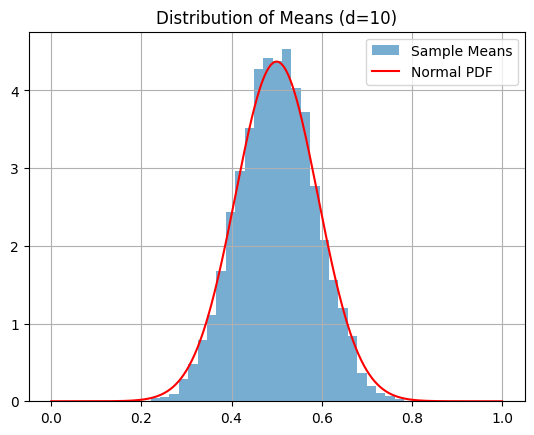

d = 10 → Estimation ≈ 0.523522
d = 20 → Estimation ≈ 0.366792
d = 50 → Estimation ≈ 0.386501


In [20]:
for d in [2, 5, 10, 20, 50]:
    I = importance_sampling(f, d, N=10000, plot=(d == 10))
    print(f"d = {d:>2} → Estimation ≈ {I:.6f}")